# Import libraries

In [42]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Connect to database

In [43]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [44]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [45]:
query="""
    select *
    from agg.tidy_data_30min 
    where site = 64
"""

In [46]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_148128\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17539 entries, 0 to 17538
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  17539 non-null  datetime64[ns, UTC]
 1   site                       17539 non-null  int64              
 2   year                       17539 non-null  int64              
 3   month                      17539 non-null  int64              
 4   day                        17539 non-null  int64              
 5   hour                       17539 non-null  int64              
 6   minute                     17539 non-null  int64              
 7   day_of_week                17539 non-null  int64              
 8   season                     17539 non-null  int64              
 9   net_load                   17539 non-null  float64            
 10  precipitation              17045 non-null  float64            
 11  pr

In [48]:
df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
0,2019-04-29 05:30:00+00:00,64,2019,4,29,6,30,0,2,14.43,...,47.0,154.0,3.0,4.0,1.0,447.46,50.6525,324.41,190.21,0
1,2019-04-12 05:30:00+00:00,64,2019,4,12,6,30,4,2,15.21,...,5.0,105.0,8.0,3.0,0.0,402.89,23.3025,336.98,204.90,0
2,2019-04-12 06:00:00+00:00,64,2019,4,12,7,0,4,2,13.57,...,6.0,114.0,8.0,24.0,22.0,439.75,16.7325,508.88,231.04,0
3,2019-04-12 06:30:00+00:00,64,2019,4,12,7,30,4,2,12.69,...,6.0,114.0,8.0,24.0,22.0,386.10,15.5350,494.11,233.37,0
4,2019-04-12 07:00:00+00:00,64,2019,4,12,8,0,4,2,14.14,...,6.0,107.0,9.0,60.0,23.0,318.46,14.7425,454.96,127.30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17534,2020-03-30 09:00:00+00:00,64,2020,3,30,10,0,0,2,11.33,...,NaN,NaN,NaN,NaN,NaN,-18.76,-20.7500,35.43,7.21,0
17535,2020-03-30 09:30:00+00:00,64,2020,3,30,10,30,0,2,8.46,...,NaN,NaN,NaN,NaN,NaN,21.09,-68.9825,65.76,6.49,0
17536,2020-03-30 10:00:00+00:00,64,2020,3,30,11,0,0,2,0.22,...,NaN,NaN,NaN,NaN,NaN,-43.60,-146.5200,85.88,8.58,0
17537,2020-03-30 10:30:00+00:00,64,2020,3,30,11,30,0,2,-5.47,...,NaN,NaN,NaN,NaN,NaN,-122.59,-169.0875,26.46,-1.58,0


In [49]:
# Convert 'ts' to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df.set_index('timestamp', inplace=True)
df = df.sort_index()

df

,site,year,month,day,hour,minute,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,0.0,2.0,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,0.0,2.0,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,0.0,3.0,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,0.0,3.0,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,0.0,6.0,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,NaN,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,NaN,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,NaN,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


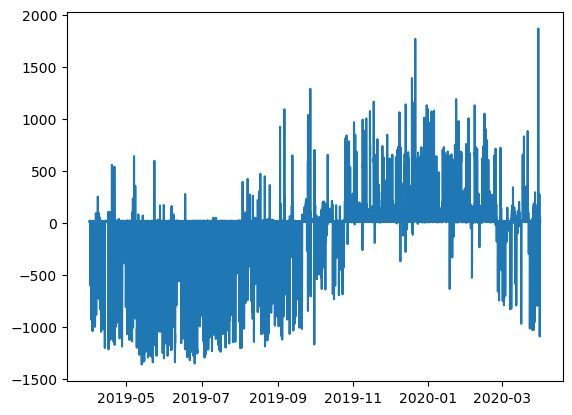

In [50]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

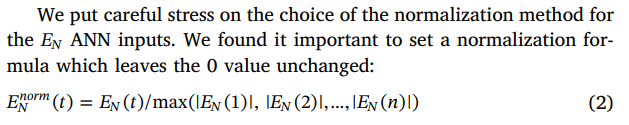



High-resolution net load forecasting for micro-neighbourhoods with high
penetration of renewable energy sources
P. Kobylinskia
, M. Wierzbowskia
, K. Piotrowskib,

In [51]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

,site,year,month,day,hour,minute,day_of_week,season,net_load,precipitation,...,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday,net_load_norm
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,0.0,...,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0,0.007819
2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,0.0,...,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0,0.008931
2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,0.0,...,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0,0.010840
2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,0.0,...,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0,0.008487
2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,0.0,...,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0,0.008086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,NaN,...,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0,0.007696
2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,NaN,...,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0,0.007867
2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,NaN,...,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0,0.007995


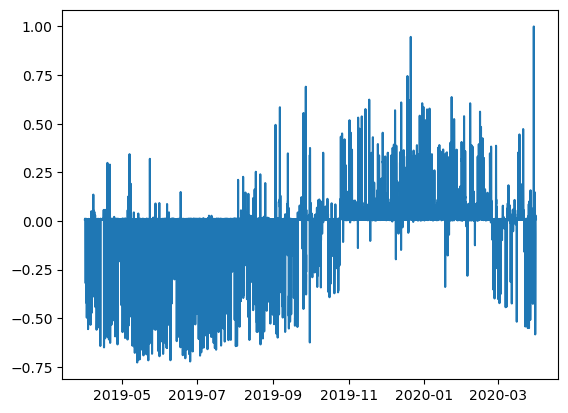

In [52]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Prepare data set for LSTM

Example \
Based on the first 5 hours, let's predict the 6th hour\
Based on the next 5 hours, let's predict the 7th hour\
etc. etc.

[[[1], [2], [3], [4], [5]]] [6] \
[[[2], [3], [4], [5], [6]]] [7] \
[[[3], [4], [5], [6], [7]]] [8]

In [207]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 2 weeks = 2 * 24 * 7 * 2 = 672
# 24 hours = 2 * 24 = 48 

n_input = 672
n_features = 1
n_output = 48  

# Turn net_load_norm into np array
net_load_norm = df['net_load_norm'].to_numpy().reshape(-1, 1)

X, y = [], []
for i in range(len(net_load_norm) - n_input - n_output + 1):
    X.append(net_load_norm[i:(i + n_input), 0])
    y.append(net_load_norm[(i + n_input):(i + n_input + n_output), 0])

X = np.array(X).reshape((len(X), n_input, n_features))
y = np.array(y)

In [208]:
X.shape

(16820, 672, 1)

In [209]:
y.shape

(16820, 48)

First set of X and y values

In [210]:
print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y: \n {y[0]}\n')

Given the array X: 
 [ 7.81855811e-03  8.93091111e-03  1.08400939e-02  8.48703948e-03
  8.08595066e-03  1.16369237e-02  1.20487082e-02  8.35869106e-03
  7.95760224e-03  7.98434149e-03  8.05921141e-03  7.51373061e-03
  7.25168591e-03  7.02172832e-03  6.58855239e-03  7.44955640e-03
  7.12333749e-03  7.26238161e-03  7.50303491e-03  7.27307731e-03
  7.34259938e-03  7.54581771e-03  7.88808017e-03  7.21959880e-03
  7.35329508e-03 -7.50891754e-02 -2.32380168e-01 -2.53402570e-01
 -2.67419288e-01 -2.74740496e-01 -3.19614313e-01 -2.52423913e-01
 -1.03791092e-01  8.75977988e-03  4.13388880e-03  7.49233920e-03
  7.49233920e-03  7.09125038e-03  7.66347043e-03  7.65277473e-03
  7.26772946e-03  7.23564236e-03  8.12338562e-03  7.95760224e-03
  7.74368820e-03  7.98968934e-03  8.02712430e-03  7.60464407e-03
  8.53517014e-03  1.15727495e-02  9.23039077e-03  7.80786241e-03
  8.40682172e-03  9.05391169e-03  8.23569049e-03  8.59934435e-03
  7.82390596e-03  8.08060281e-03  8.52982229e-03  7.03242402e-03
  7.

Second set of X and y values

In [211]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

Given the array X: 
 [ 8.93091111e-03  1.08400939e-02  8.48703948e-03  8.08595066e-03
  1.16369237e-02  1.20487082e-02  8.35869106e-03  7.95760224e-03
  7.98434149e-03  8.05921141e-03  7.51373061e-03  7.25168591e-03
  7.02172832e-03  6.58855239e-03  7.44955640e-03  7.12333749e-03
  7.26238161e-03  7.50303491e-03  7.27307731e-03  7.34259938e-03
  7.54581771e-03  7.88808017e-03  7.21959880e-03  7.35329508e-03
 -7.50891754e-02 -2.32380168e-01 -2.53402570e-01 -2.67419288e-01
 -2.74740496e-01 -3.19614313e-01 -2.52423913e-01 -1.03791092e-01
  8.75977988e-03  4.13388880e-03  7.49233920e-03  7.49233920e-03
  7.09125038e-03  7.66347043e-03  7.65277473e-03  7.26772946e-03
  7.23564236e-03  8.12338562e-03  7.95760224e-03  7.74368820e-03
  7.98968934e-03  8.02712430e-03  7.60464407e-03  8.53517014e-03
  1.15727495e-02  9.23039077e-03  7.80786241e-03  8.40682172e-03
  9.05391169e-03  8.23569049e-03  8.59934435e-03  7.82390596e-03
  8.08060281e-03  8.52982229e-03  7.03242402e-03  7.48164350e-03
  7.

# Split into train (First 300 days)

In [212]:
# 1 time step = 30 mins

n_split = 2 * 24 * 300 

X_train = X[:n_split]
y_train = y[:n_split]

In [213]:
X_train.shape

(14400, 672, 1)

In [214]:
y_train.shape

(14400, 48)

# Build LSTM model

### Model 1

In [215]:
model1 = Sequential()
model1.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

c:\Users\elian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 672, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,896 (120.69 KB)

 Trainable params: 30,896 (120.69 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])

# Fit LSTM model

In [217]:
history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)

Epoch 1/10
285/810 ━━━━━━━━━━━━━━━━━━━━ 1:15 144ms/step - loss: 0.0282 - mean_squared_error: 0.0282

# Check training results

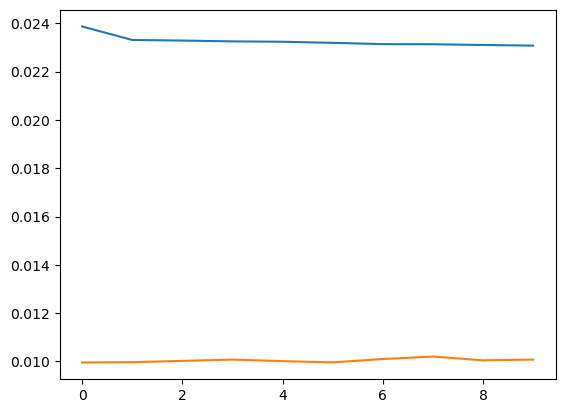

In [191]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Plot training results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


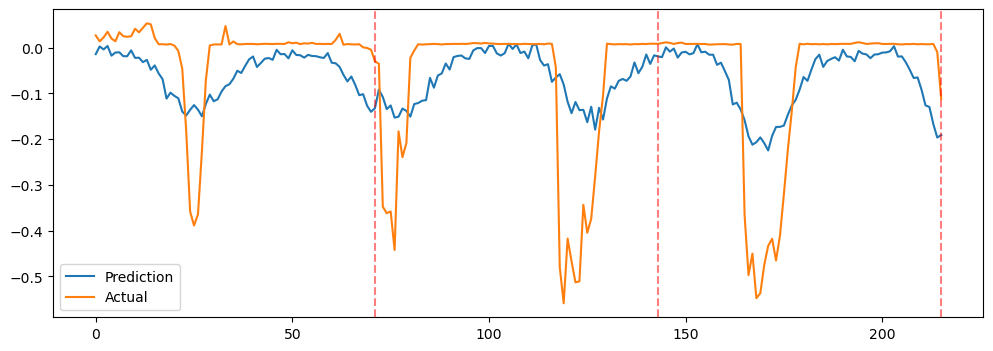

In [206]:
# Paramets to change to see the training results

# 1 = 36 hour period

start_section = 0
end_section = 3

# Select every 72th sample
X_train_input = X_train[::n_output]
y_train_input = y_train[::n_output]


predictions = []

for i in X_train_input[0:3]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_train_input[0:3].flatten(), label = 'Actual')

xcoords = [(i*72)-1+72 for i in range(start_section, end_section)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



plt.legend()

# Check validation results

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Validation Results")
plt.plot(ts_val, val_results['Actuals'], label='Actual')
plt.plot(ts_val, val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_val, val_predictions)}")

# Check test results

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Testing Results")
plt.plot(ts_test, test_results['Actuals'], label='Actual')
plt.plot(ts_test, test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_test, test_predictions)}")